In [1]:
# %%
import os
import sys
import logging

import Bio
import matplotlib as mpl
import matplotlib.image as img 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import csv
from tqdm.notebook import tqdm
import pptx
import pdf2image
from sklearn import cluster
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import squareform

%load_ext autoreload
%autoreload 2
sys.path.append('..')
import medicc
import medicc.plot as mplot
import fstlib
%matplotlib inline

INFO:fstlib.ext:Using accelerated C operations.


In [2]:
def clear_medicc_logging():
    for logger_name in ['medicc.core', 'medicc.io', 'medicc.nj']:
        logger = logging.getLogger(logger_name)
        logger.setLevel(logging.CRITICAL) # defaults to INFO

In [3]:
clear_medicc_logging()

# Plotting CNP

In [335]:
# %%
data_folder = "../examples/output_gundem_et_al_2015"
patients = np.sort([f.split('_')[2] for f in os.listdir(data_folder) if 'final_cn_profiles.tsv' in f])

patient = patients[0]

cur_df = medicc.io.read_tsv_as_dataframe(
    os.path.join(data_folder, "20210303_G_{}_gundem_phased_data_intersection_1mb_homdel_correct_df_final_cn_profiles.tsv".format(patient)))
cur_tree = medicc.io.import_tree(
    os.path.join(data_folder, "20210303_G_{}_gundem_phased_data_intersection_1mb_homdel_correct_df_final_tree.new".format(patient)), 'diploid')

labels = {'diploid': 'Diploid'}
for label in cur_df.reset_index()['sample_id']:
    if 'diploid' not in label and 'internal' not in label:
        labels[label] = '_'.join([label.split('_')[1].split('-')[0], label.split('_')[-1]])

INFO:medicc.io:Reading TSV file ../examples/output_gundem_et_al_2015/20210303_G_PTX004_gundem_phased_data_intersection_1mb_homdel_correct_df_final_cn_profiles.tsv
INFO:medicc.io:Successfully read input file. Using columns {sample_id, chrom, start, end, cn_a, cn_b}


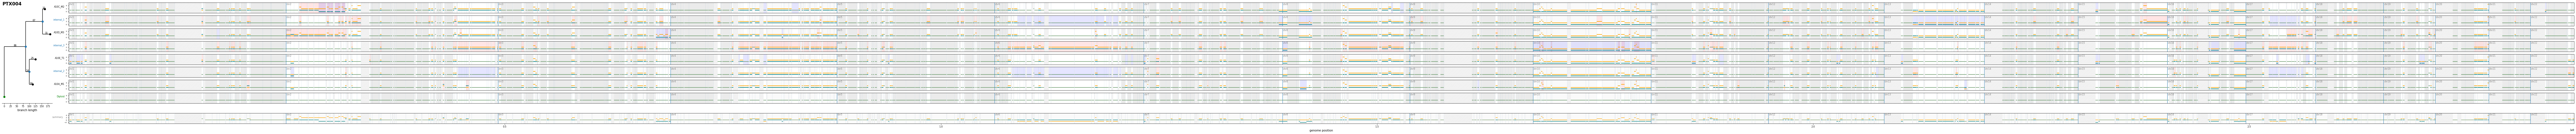

In [359]:
fig = medicc.plot.plot_cn_profiles(
        cur_df,
        cur_tree,
        title=patient,
        normal_name='diploid',
        hide_normal_chromosomes=False,
        ignore_segment_lengths=False,
        label_func=lambda label: labels.get(label, label))
for ax in fig.get_axes():
    ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment='right')


## Hiding internals

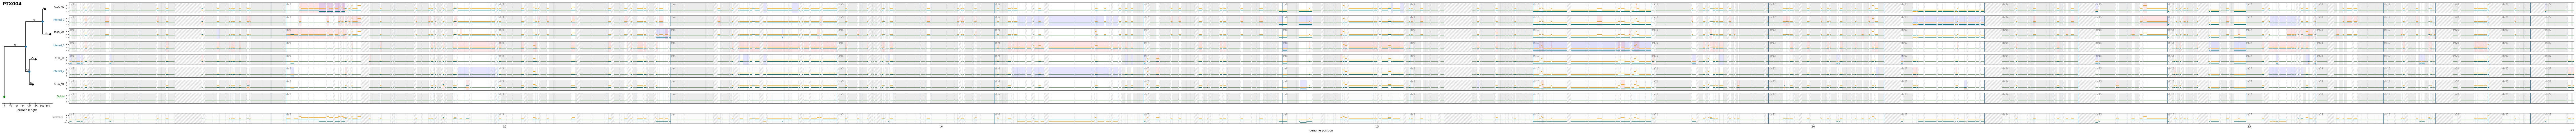

In [389]:
fig = medicc.plot.plot_cn_profiles(
        cur_df,
        cur_tree,
        title=patient,
        hide_internal_nodes=False,
        normal_name='diploid',
        hide_normal_chromosomes=False,
        ignore_segment_lengths=False,
        label_func=lambda label: labels.get(label, label))
for ax in fig.get_axes():
    ax.set_ylabel(ax.get_ylabel(), rotation=0, horizontalalignment='right')

# Sattoriva data

In [5]:
def plot_tree(input_tree, label_func, title='', ax=None, output_name=None, plot_branch_lengths=False):

    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 7))

    TREE_MARKER_SIZE = 40
    XLABEL_FONT_SIZE = 10
    XLABEL_TICK_SIZE = 8
    COL_MARKER_INTERNAL = '#1f77b4'
    COL_MARKER_TERMINAL = 'black'
    # COL_MARKER_TERMINAL = 'white'
    COL_MARKER_NORMAL = 'green'
    
    if plot_branch_lengths:
        branch_labels=lambda x: np.round(x.branch_length, 1) if x.name!='root' and x.name is not None else None
    else:
        branch_labels=None

    clade_colors = {}
    normal_name = 'diploid'
    for sample in [x.name for x in list(input_tree.find_clades(''))]:
        ## determine if sample is terminal
        is_terminal = True
        if input_tree is not None:
            matches = list(input_tree.find_clades(sample))
            if len(matches) > 0:
                clade = matches[0]
                is_terminal = clade.is_terminal()
        ## determine if sample is normal
        is_normal = sample == normal_name
        clade_colors[sample] = COL_MARKER_TERMINAL
        if not is_terminal:
            clade_colors[sample] = COL_MARKER_INTERNAL
        if is_normal:
            clade_colors[sample] = COL_MARKER_NORMAL

    ax.axes.get_yaxis().set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True, prune=None))
    ax.xaxis.set_tick_params(labelsize=XLABEL_TICK_SIZE)
    ax.xaxis.label.set_size(XLABEL_FONT_SIZE)
    ax.set_title(title, x=0.01, y=0.99, ha='left', va='top', fontweight='bold', fontsize=16)
    x_posns = mplot._get_x_positions(input_tree)
    y_posns = mplot._get_y_positions(input_tree, adjust=True)
    mplot._draw_tree(input_tree,
                     x_posns,
                     y_posns,
                     label_func=label_func,
                     branch_labels=branch_labels,
                     #         branch_labels=lambda x:np.round(x.branch_length, 1) if x.name!='root' and x.name is not None else None,
                     marker_func=lambda x: (
                         TREE_MARKER_SIZE, clade_colors[x.name]) if x.name is not None else None,
                     axes=ax)
    if output_name is not None:
        plt.savefig(output_name + ".png")

    
def label_func(label):
    label = str(label)
    if 'C_STX' in label:
        label = label.split('-')[-1] + '_' + patient_info.loc[patient_info['tx_region'] ==
                                label, 'description'].iloc[0].split('(')[-1].split(' ')[0]
        return label
    elif 'Clade' in label:
        return ''
    else:
        return label

In [6]:
fst_wgd = fstlib.read(os.path.join('../objects', 'wgd_asymm.fst'))
fst_nowgd = fstlib.read(os.path.join('../objects', 'no_wgd_asymm.fst'))

normal_name = 'diploid'

data_folder = '../../data/sottoriva_bafseg_old_snpphase_output'
files = np.sort([f for f in os.listdir(data_folder) if 'pyclone_format' in f and 'reformated' in f])

patient_info = pd.read_csv('../../data/tx_format_sottoriva_key.txt', sep='\t')
patient_dict = {}
patient_dict_reversed = {}
for pat in patient_info['tx_patient'].unique():
    numeric = patient_info.loc[patient_info['tx_patient'] == pat, 'orig_patient'].iloc[0]
    stx = pat.split('_')[1]
    
    patient_dict[stx] = numeric
    patient_dict_reversed[numeric] = stx
    
patient_info_2 = pd.read_csv('../../data/sottoriva_patient_info_2.txt', sep='\t')

## Patient Info

In [390]:
patient_info_2[['Source Name', 'Characteristics[clinical information] ']].values

array([['KA1', 'tumor gland (right side)'],
       ['KA2', 'tumor gland (right side)'],
       ['KA3', 'tumor gland (right side)'],
       ['KA4L', 'tumor gland (right side)'],
       ['KA5', 'tumor gland (right side)'],
       ['KA6', 'tumor gland (right side)'],
       ['KB2L', 'tumor gland (left side)'],
       ['KB4', 'tumor gland (left side)'],
       ['KB5', 'tumor gland (left side)'],
       ['KB6', 'tumor gland (left side)'],
       ['KB7', 'tumor gland (left side)'],
       ['KB9', 'tumor gland (left side)'],
       ['MA1', 'tumor gland (right side)'],
       ['MA2L', 'tumor gland (right side)'],
       ['MA3', 'tumor gland (right side)'],
       ['MA4', 'tumor gland (right side)'],
       ['MA5L', 'tumor gland (right side)'],
       ['MA6L', 'tumor gland (right side)'],
       ['MA7L', 'tumor gland (right side)'],
       ['MB1', 'tumor gland (left side)'],
       ['MB2', 'tumor gland (left side)'],
       ['MB3L', 'tumor gland (left side)'],
       ['MB4L', 'tumor gland (left

In [367]:
patient_info_4 = pd.read_csv('../../data/sottoriva_patient_info_4.txt', sep='\t')

In [435]:
patient_info_4.loc[patient_info_4['Characteristics[individual]'] == 'K'].groupby('Characteristics[clinical information]').count()

,Source Name,Material Type,Provider,Characteristics[organism],Characteristics[specimen with known storage state],Characteristics[sex],Characteristics[age],Unit[time unit],Characteristics[disease],Characteristics[individual],...,Label,Protocol REF.3,Assay Name,Array Design REF,Technology Type,Protocol REF.4,Array Data File,Comment [ArrayExpress FTP file],Factor Value[individual],Factor Value[clinical information]
Characteristics[clinical information],,,,,,,,,,,,,,,,,,,,,
normal (adjacent),1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
tumor bulk (left side),1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
tumor bulk (right side),1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
tumor gland (left side),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
tumor gland (right side),4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [504]:
patient_info_4['Characteristics[individual]'].unique()

array(['CA', 'CO', 'G', 'K', 'M', 'N', 'O', 'P', 'R', 'S', 'Z', 'T', 'U',
       'W', 'X'], dtype=object)

In [449]:
patient_info_4.loc[patient_info_4['Characteristics[individual]'] == 'K', ['Source Name', 'Characteristics[clinical information]']]

,Source Name,Characteristics[clinical information]
31,KA_1,tumor gland (right side)
32,KA_2,tumor gland (right side)
33,KA_6,tumor gland (right side)
34,KA_7,tumor gland (right side)
35,KA,tumor bulk (right side)
36,KB_1,tumor gland (left side)
37,KB_3,tumor gland (left side)
38,KB_4,tumor gland (left side)
39,KB_5,tumor gland (left side)
40,KB,tumor bulk (left side)


In [442]:
patient_info_2.loc[patient_info_2['Characteristics[individual]'] == 'K', ['Source Name', 'Characteristics[clinical information] ']]

,Source Name,Characteristics[clinical information]
0,KA1,tumor gland (right side)
1,KA2,tumor gland (right side)
2,KA3,tumor gland (right side)
3,KA4L,tumor gland (right side)
4,KA5,tumor gland (right side)
5,KA6,tumor gland (right side)
6,KB2L,tumor gland (left side)
7,KB4,tumor gland (left side)
8,KB5,tumor gland (left side)
9,KB6,tumor gland (left side)


In [453]:
pd.crosstab(patient_info_2['Characteristics[individual]'], patient_info_2['Characteristics[clinical information] '])

Characteristics[clinical information],normal tissue adjacent to the tumor,tumor bulk (left side),tumor bulk (right side),tumor gland (left side),tumor gland (right side)
Characteristics[individual],,,,,
G,1,1,1,0,0
K,3,3,3,6,6
M,3,3,3,7,8
N,3,3,3,5,5
O,2,3,3,5,6
P,3,3,3,4,3
S,3,3,3,4,4
T,2,3,3,5,5
U,2,3,3,5,5


In [1046]:
patient_info.loc[patient_info['orig_patient'] == 'M', ['description', 'tx_region']]

,description,tx_region
42,normal (adjacent),C_STX005_BS_GL
43,tumor bulk (left side),C_STX005_SU_T1-R1
44,tumor gland (left side),C_STX005_SU_T1-R2
45,tumor gland (left side),C_STX005_SU_T1-R3
46,tumor gland (left side),C_STX005_SU_T1-R4
47,tumor gland (left side),C_STX005_SU_T1-R5
48,tumor gland (left side),C_STX005_SU_T1-R6
49,tumor bulk (right side),C_STX005_SU_T1-R7
50,tumor gland (right side),C_STX005_SU_T1-R8
51,tumor gland (right side),C_STX005_SU_T1-R9


## original trees from the paper

In [348]:
def label_func_orig(label):
    label = str(label)
    if 'internal' in label or label == 'diploid':
        return label
    else:
        return label

In [349]:
orig_tree_df = pd.read_csv('../../data/sottoriva_orig_trees.csv')

orig_tree_df['phylogeny'].to_csv('../../data/sottoriva_orig_trees_.txt', 
                                 header=False, index=False, quoting = csv.QUOTE_NONE, escapechar=' ')

tumors = orig_tree_df['tumor'].values

trees = Bio.Phylo.parse('../../data/sottoriva_orig_trees_.txt', 'newick')
trees = list(trees)
# for tree in trees:
#     tree.root_with_outgroup('diploid')

In [350]:
patient_info.loc[patient_info['orig_patient']=='K', 'array'].values

array(['KN', 'KB', 'KB_5', 'KB_4', 'KB_3', 'KB_1', 'KA', 'KA_7', 'KA_6',
       'KA_2', 'KA_1'], dtype=object)

In [401]:
np.sort([x.name for x in list(trees[0].find_clades()) if 'internal' not in x.name and 'diploid' not in x.name])

array(['KA1', 'KA2', 'KA3', 'KA4L', 'KA5', 'KA6', 'KB2L', 'KB4', 'KB5',
       'KB6', 'KB7', 'KB9'], dtype='<U4')

In [414]:
cur_info = pd.DataFrame(columns=patient_info_2.columns)
for node in np.sort([x.name for x in list(trees[0].find_clades()) if 'internal' not in x.name and 'diploid' not in x.name]):
    cur_info = cur_info.append(patient_info_2.loc[patient_info_2['Source Name']==node])

In [448]:
patient_info_2.loc[patient_info_2['Characteristics[individual]']=='K', ['Source Name', 'Characteristics[clinical information] ']]

,Source Name,Characteristics[clinical information]
0,KA1,tumor gland (right side)
1,KA2,tumor gland (right side)
2,KA3,tumor gland (right side)
3,KA4L,tumor gland (right side)
4,KA5,tumor gland (right side)
5,KA6,tumor gland (right side)
6,KB2L,tumor gland (left side)
7,KB4,tumor gland (left side)
8,KB5,tumor gland (left side)
9,KB6,tumor gland (left side)


In [352]:
orig_tree_df.loc[0, 'phylogeny']

'(((KA4L:0.00000,(KA6:0.00000,KA3:0.00000)internal_7:2.00000)internal_4:1.00000,((KA2:0.00000,KA1:0.00000)internal_8:0.00000,KA5:0.00000)internal_5:2.00000)internal_2:12.00000,(KB2L:0.00000,((KB9:0.00000,KB7:0.00000)internal_9:0.00000,((KB5:0.00000,KB4:0.00000)internal_11:0.00000,KB6:0.00000)internal_10:0.00000)internal_6:1.00000)internal_3:12.00000,diploid:0.00000)internal_1:0.00000;'

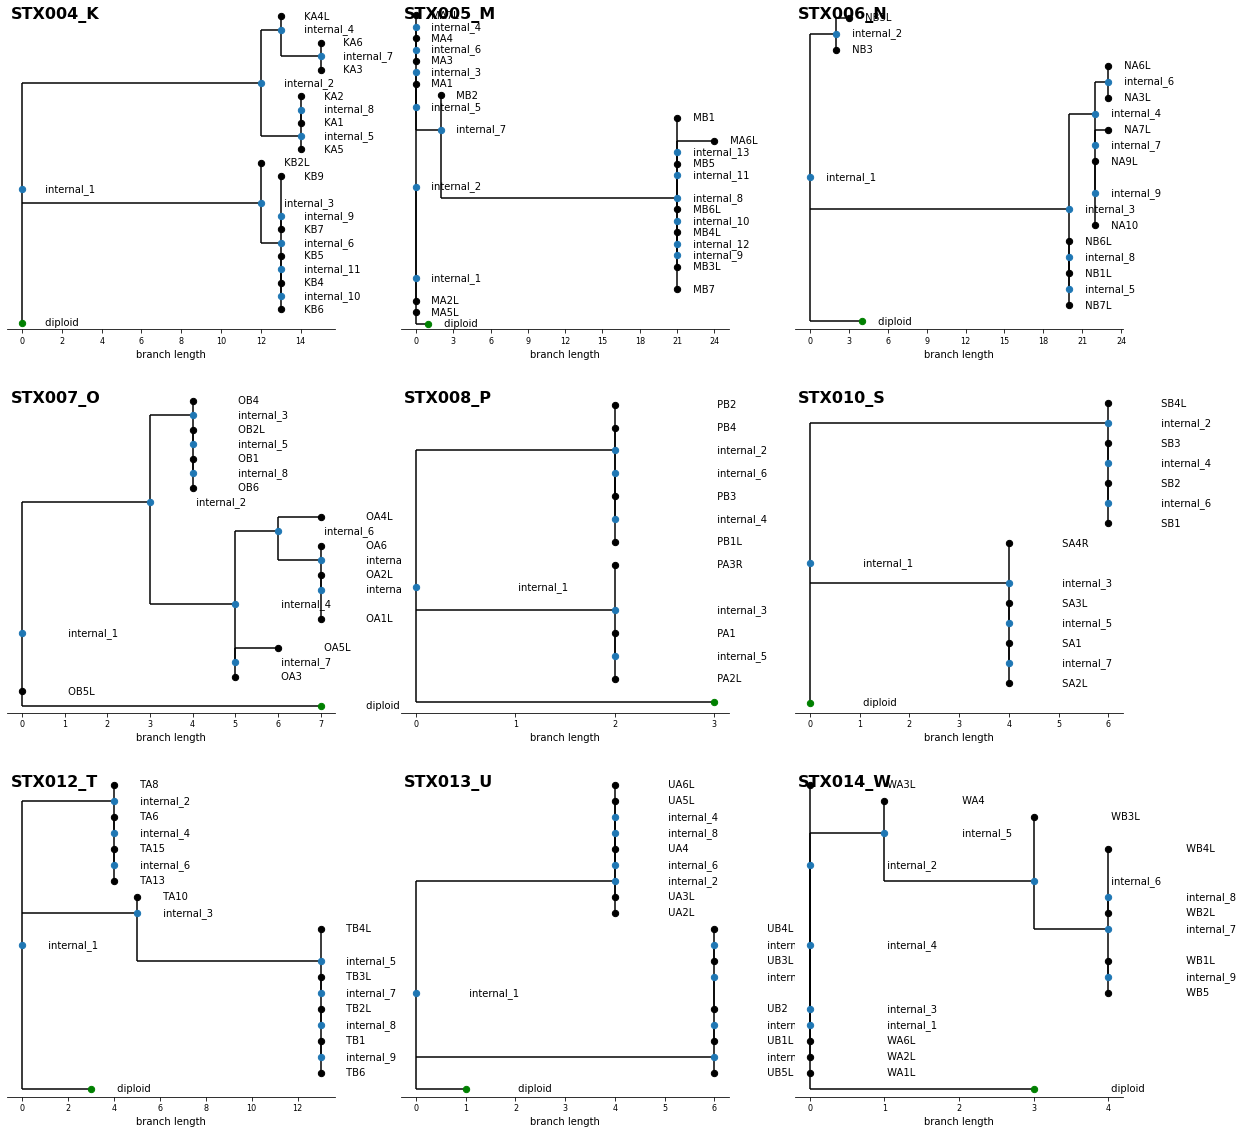

In [502]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))

for tree, tumor, ax in zip(trees, tumors, axs.ravel()):
    plot_tree(tree, ax=ax, label_func=label_func_orig, title='{}_{}'.format(patient_dict_reversed[tumor], tumor))
    
plt.savefig('../../results/sottoriva_original_trees.pdf')

## Join neighboring segments?

In [192]:
cur_file = files[0] 
patient_stx = cur_file.split('_')[2]
patient_orig = patient_dict[patient_stx]
input_df = medicc.io.read_and_parse_input_data(
    os.path.join(data_folder, cur_file),
    normal_name,
    'tsv',
    'X',
    ['A', 'B'])
input_df.rename({'A': 'cn_a', 'B': 'cn_b'}, axis=1, inplace=True)

INFO:medicc.io:Reading Refphase TSV input.
INFO:medicc.io:Reading TSV file ../../data/sottoriva_bafseg_old_snpphase_output/reformated_C_STX001_pyclone_format_segments.txt
INFO:medicc.io:Successfully read input file. Using columns {sample, chr, startpos, endpos, A, B}
INFO:medicc.io:Normal sample 'diploid' not found, adding artifical normal by the name: 'diploid'.
INFO:medicc.io:Read 10 samples, 22 chromosomes, 282 segments per sample


In [229]:
gaps = input_df.reset_index()['start'] - np.roll(input_df.reset_index()['end'], 1)
gaps[gaps<0] = -1

In [237]:
(gaps < 100).sum() - (gaps == -1).sum()

70

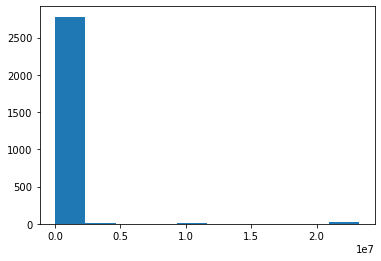

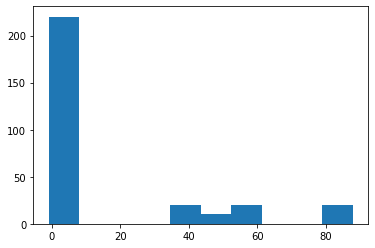

In [238]:
plt.hist(gaps)
plt.show()

plt.hist(gaps[gaps<100])
plt.show()

## Run MEDICC and plot trees/CNP 

7 files * 4 conditions * 5 filters * 15 patients ==> 140 files per patient --> 2100 files in total  

In [47]:
if False:
    for cur_file in tqdm(files):
        for filter_segment_length in [0, 2.5e5, 5e5, 7.5e5, 1e6]:

            output_dir = '../../results/sottoriva_bafseq/filter_{}'.format(str(int(filter_segment_length)))

            patient_stx = cur_file.split('_')[2]
            patient_orig = patient_dict[patient_stx]
            input_df = medicc.io.read_and_parse_input_data(
                os.path.join(data_folder, cur_file),
                normal_name,
                'tsv',
                'X',
                ['A', 'B'])
            input_df.rename({'A': 'cn_a', 'B': 'cn_b'}, axis=1, inplace=True)

            if filter_segment_length > 0:
                input_df.reset_index(inplace=True)
                input_df['segment_length'] = input_df['end'] - input_df['start']
                input_df = input_df.loc[input_df['segment_length'] > filter_segment_length]

                input_df.set_index(['sample_id', 'chrom', 'start', 'end'], inplace=True)
                input_df.sort_index(inplace=True)
                input_df = input_df[['cn_a', 'cn_b']]

            # phased
            sample_labels, pdms, nj_tree, final_tree, output_df = medicc.main(
                input_df,
                fst_wgd,
                normal_name,
                input_tree=None,
                ancestral_reconstruction=True,
                chr_separator='X')

            plot_tree(final_tree,
                      label_func,
                    output_name=os.path.join(output_dir, '{}_{}_phased_WGD_tree'.format(patient_stx, patient_orig)),
                    title='{}_{}'.format(patient_stx, patient_orig))

            p = medicc.plot.plot_cn_profiles(
                output_df,
                final_tree,
                title='{}_{}'.format(patient_stx, patient_orig),
                normal_name=normal_name,
                plot_summary=True,
                label_func=label_func)
            p.savefig(os.path.join(output_dir, '{}_{}_phased_WGD_cn_profiles.pdf'.format(patient_stx, patient_orig)))
            plt.close()

            Bio.Phylo.write(nj_tree, os.path.join(output_dir, '{}_{}_phased_WGD_nj_tree.new'.format(patient_stx, patient_orig)), "newick")
            Bio.Phylo.write(final_tree, os.path.join(output_dir, '{}_{}_phased_WGD_final_tree.new'.format(patient_stx, patient_orig)), "newick")
            medicc.io.write_pdms(sample_labels, pdms, os.path.join(output_dir, '{}_{}_phased_WGD_pdms'.format(patient_stx, patient_orig)))
            
            ######

            sample_labels, pdms, nj_tree, final_tree, output_df = medicc.main(
                input_df,
                fst_nowgd,
                normal_name,
                input_tree=None,
                ancestral_reconstruction=True,
                chr_separator='X')

            plot_tree(final_tree,
                      label_func,
                    output_name=os.path.join(output_dir, '{}_{}_phased_noWGD_tree'.format(patient_stx, patient_orig)),
                    title='{}_{}'.format(patient_stx, patient_orig))

            p = medicc.plot.plot_cn_profiles(
                output_df,
                final_tree,
                title='{}_{}'.format(patient_stx, patient_orig),
                normal_name=normal_name,
                plot_summary=True,
                label_func=label_func)
            p.savefig(os.path.join(output_dir, '{}_{}_phased_noWGD_cn_profiles.pdf'.format(patient_stx, patient_orig)))
            plt.close()
            
            Bio.Phylo.write(nj_tree, os.path.join(output_dir, '{}_{}_phased_noWGD_nj_tree.new'.format(patient_stx, patient_orig)), "newick")
            Bio.Phylo.write(final_tree, os.path.join(output_dir, '{}_{}_phased_noWGD_final_tree.new'.format(patient_stx, patient_orig)), "newick")
            medicc.io.write_pdms(sample_labels, pdms, os.path.join(output_dir, '{}_{}_phased_noWGD_pdms'.format(patient_stx, patient_orig)))

            # unphased
            
            input_df.loc[:, ['cn_a', 'cn_b']] = np.sort(input_df[['cn_a', 'cn_b']].values.astype(int), axis=1).astype(str)

            sample_labels, pdms, nj_tree, final_tree, output_df = medicc.main(
                input_df,
                fst_wgd,
                normal_name,
                input_tree=None,
                ancestral_reconstruction=True,
                chr_separator='X')

            plot_tree(final_tree,
                      label_func,
                      output_name=os.path.join(output_dir, '{}_{}_unphased_WGD_tree'.format(patient_stx, patient_orig)),
                        title='{}_{}'.format(patient_stx, patient_orig))

            p = medicc.plot.plot_cn_profiles(
                output_df,
                final_tree,
                title='{}_{}'.format(patient_stx, patient_orig),
                normal_name=normal_name,
                plot_summary=True,
                label_func=label_func)
            p.savefig(os.path.join(output_dir, '{}_{}_unphased_WGD_cn_profiles.pdf'.format(patient_stx, patient_orig)))
            plt.close()
            
            Bio.Phylo.write(nj_tree, os.path.join(output_dir, '{}_{}_unphased_WGD_nj_tree.new'.format(patient_stx, patient_orig)), "newick")
            Bio.Phylo.write(final_tree, os.path.join(output_dir, '{}_{}_unphased_WGD_final_tree.new'.format(patient_stx, patient_orig)), "newick")
            medicc.io.write_pdms(sample_labels, pdms, os.path.join(output_dir, '{}_{}_unphased_WGD_pdms'.format(patient_stx, patient_orig)))
            
            ###
            
            sample_labels, pdms, nj_tree, final_tree, output_df = medicc.main(
                input_df,
                fst_nowgd,
                normal_name,
                input_tree=None,
                ancestral_reconstruction=True,
                chr_separator='X')

            plot_tree(final_tree,
                      label_func,
                    output_name=os.path.join(output_dir, '{}_{}_unphased_noWGD_tree'.format(patient_stx, patient_orig)),
                    title='{}_{}'.format(patient_stx, patient_orig))

            p = medicc.plot.plot_cn_profiles(
                output_df,
                final_tree,
                title='{}_{}'.format(patient_stx, patient_orig),
                normal_name=normal_name,
                plot_summary=True,
                label_func=label_func)
            p.savefig(os.path.join(output_dir, '{}_{}_unphased_noWGD_cn_profiles.pdf'.format(patient_stx, patient_orig)))
            plt.close()

            plt.close('all')
            
            Bio.Phylo.write(nj_tree, os.path.join(output_dir, '{}_{}_unphased_noWGD_nj_tree.new'.format(patient_stx, patient_orig)), "newick")
            Bio.Phylo.write(final_tree, os.path.join(output_dir, '{}_{}_unphased_noWGD_final_tree.new'.format(patient_stx, patient_orig)), "newick")
            medicc.io.write_pdms(sample_labels, pdms, os.path.join(output_dir, '{}_{}_unphased_noWGD_pdms'.format(patient_stx, patient_orig)))

## Compare phased/WGD/cutoffs

In [ ]:
for cur_file in tqdm(files):

    patient_stx = cur_file.split('_')[2]
    patient_orig = patient_dict[patient_stx]

    fig, axs = plt.subplots(ncols=4, nrows=5, figsize=(30, 40))

    for filter_segment_length, ax in zip([0, 2.5e5, 5e5, 7.5e5, 1e6], axs):
        
        cur_dir = '../../results/sottoriva_bafseq/filter_{}'.format(str(int(filter_segment_length)))
        
        tree = Bio.Phylo.parse(os.path.join(cur_dir, '{}_{}_unphased_noWGD_final_tree.new'.format(patient_stx, patient_orig)), 'newick')
        tree = list(tree)[0]   
        plot_tree(tree, label_func, ax=ax[0])

        tree = Bio.Phylo.parse(os.path.join(cur_dir, '{}_{}_unphased_WGD_final_tree.new'.format(patient_stx, patient_orig)), 'newick')
        tree = list(tree)[0]   
        plot_tree(tree, label_func, ax=ax[1])

        tree = Bio.Phylo.parse(os.path.join(cur_dir, '{}_{}_phased_noWGD_final_tree.new'.format(patient_stx, patient_orig)), 'newick')
        tree = list(tree)[0]   
        plot_tree(tree, label_func, ax=ax[2])

        tree = Bio.Phylo.parse(os.path.join(cur_dir, '{}_{}_phased_WGD_final_tree.new'.format(patient_stx, patient_orig)), 'newick')
        tree = list(tree)[0]   
        plot_tree(tree, label_func, ax=ax[3])

    for ax in axs.ravel():
        ax.set_axis_off()

    axs[0, 0].set_title('unphased no WGD', fontsize=20)
    axs[0, 1].set_title('unphased WGD', fontsize=20)
    axs[0, 2].set_title('phased no WGD', fontsize=20)
    axs[0, 3].set_title('phased WGD', fontsize=20)

    for filter_segment_length, ax in zip([0, 2.5e5, 5e5, 7.5e5, 1e6], axs):
        ax[0].text(100, 250, 'cutoff: ' + str(int(filter_segment_length)), fontsize=20)
        
    plt.tight_layout()

    plt.savefig('../../results/sottoriva_bafseq/comparison/{}_{}.pdf'.format(patient_stx, patient_orig),
               bbox_to_inches='tight', pad=0, facecolor='white')
    plt.savefig('../../results/sottoriva_bafseq/comparison/{}_{}.png'.format(patient_stx, patient_orig),
               bbox_to_inches='tight', pad=0, facecolor='white')
    plt.close()

  0%|          | 0/15 [00:00<?, ?it/s]

<ipython-input-52-be4c070af13b>:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
<ipython-input-52-be4c070af13b>:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../../results/sottoriva_bafseq/comparison/{}_{}.pdf'.format(patient_stx, patient_orig),
<ipython-input-52-be4c070af13b>:41: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "pad" which is no longer supported as of 3.3 and will become an error two minor releases later
  plt.savefig('../../results/sottoriva_bafseq/comparison/{}_{}.pdf'.format(patient_stx, patient_orig),
<ipython-input-52-be4c070af13b>:43: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_to_inches" which is no longer supported as of 3.3 and will become an error

In [588]:
DPI = 200
THREAD_COUNT = 4
USE_CROPBOX = False
STRICT = False

cur_dir = '../../results/sottoriva_bafseq/filter_0'

for f in tqdm([f for f in os.listdir(cur_dir) if '_phased_WGD_cn_profiles.pdf' in f]):
    if not os.path.isfile(os.path.join(cur_dir, f.split('.')[0] + '.jpg')):
        print(f)
        pdf_path = os.path.join(cur_dir, f)

        print('loading image')
        pil_images = pdf2image.convert_from_path(pdf_path, dpi=DPI, first_page=FIRST_PAGE, fmt=FORMAT, thread_count=THREAD_COUNT, use_cropbox=USE_CROPBOX, strict=STRICT)
        if len(pil_images):
            print('saving image')
            pil_images[0].save(os.path.join(cur_dir, f.split('.')[0] + '.jpg'))

  0%|          | 0/15 [00:00<?, ?it/s]

STX007_O_phased_WGD_cn_profiles.pdf
loading image


## Plotting BAF

## Neighbor Joining / Tree Creation

### For patient STX013

In [1114]:
cur_file = files[12]

patient_stx = cur_file.split('_')[2]
patient_orig = patient_dict[patient_stx]
input_df = medicc.io.read_and_parse_input_data(
    os.path.join(data_folder, cur_file),
    normal_name,
    'tsv',
    'X',
    ['A', 'B'])
input_df.rename({'A': 'cn_a', 'B': 'cn_b'}, axis=1, inplace=True)

# phased
sample_labels, pdms, nj_tree, final_tree, output_df = medicc.main(
    input_df,
    fst_wgd,
    normal_name,
    input_tree=None,
    ancestral_reconstruction=True,
    chr_separator='X',
    logging_level='CRITICAL')

samples = [label_func(s) for s in sample_labels]

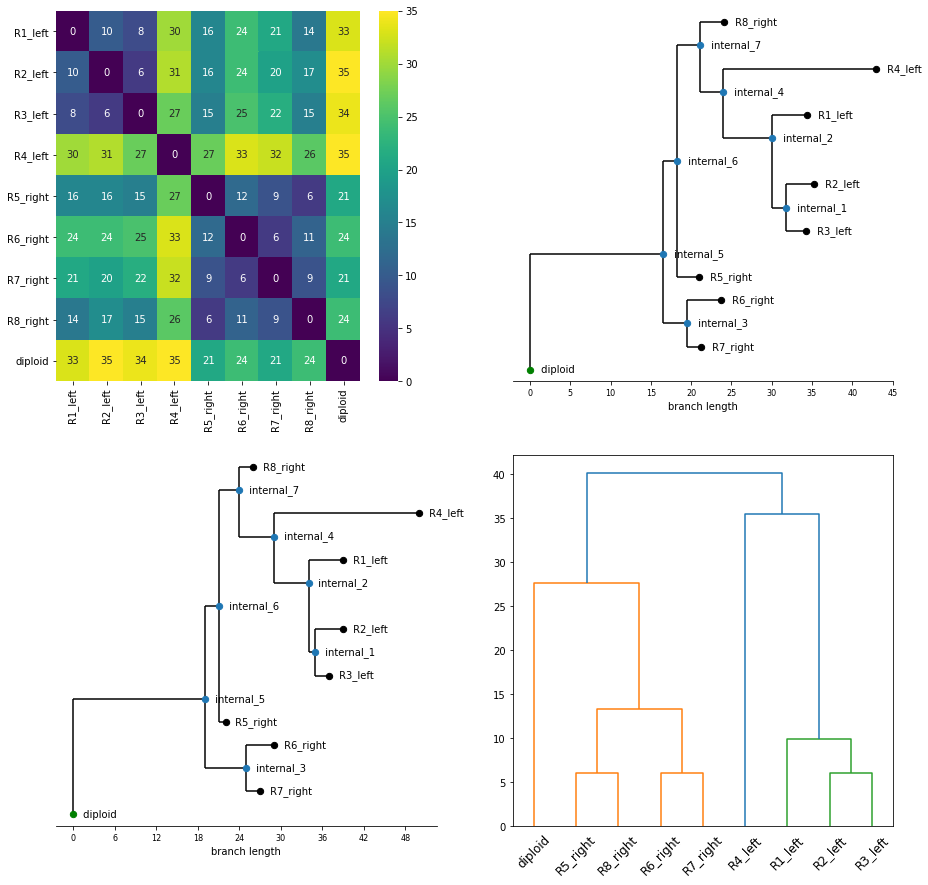

In [732]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
axs = axs.ravel()

sns.heatmap(pdms['total'], ax=axs[0], cmap='viridis', annot=True)
axs[0].set_xticklabels(samples, rotation=90)
axs[0].set_yticklabels(samples, rotation=0)

plot_tree(nj_tree, label_func, ax=axs[1])
plot_tree(final_tree, label_func, ax=axs[2])

Z = linkage(squareform(pdms['total']), method='ward')
dendrogram(Z, ax=axs[3])
axs[3].set_xticklabels([samples[int(x.get_text())]for x in axs[3].get_xticklabels()], rotation=45)
plt.show()

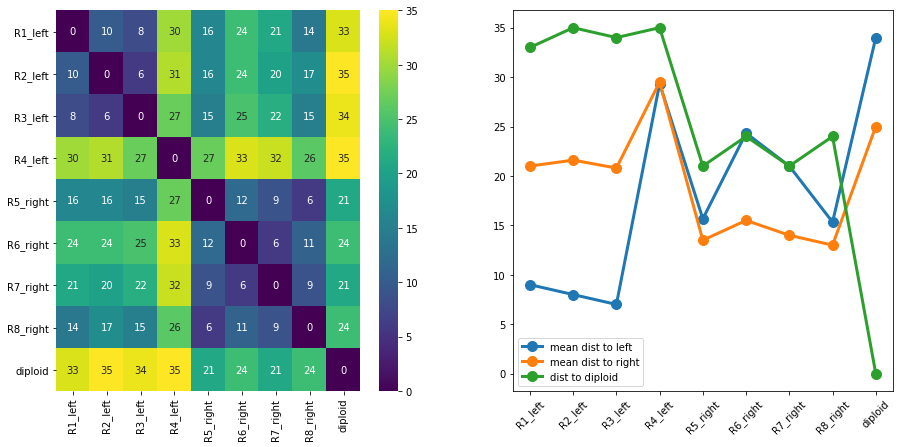

In [854]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

dist_left = np.mean(pdms['total'][:, :3], axis=1, where=pdms['total'][:, :3] > 0)
dist_right = np.mean(pdms['total'][:, 3:-1], axis=1, where=pdms['total'][:, 3:-1] > 0)
dist_diploid = pdms['total'][:, -1]

axs[1].plot(dist_left, 'o-', label='mean dist to left', lw=3, ms=10)
axs[1].plot(dist_right, 'o-', label='mean dist to right', lw=3, ms=10)
axs[1].plot(dist_diploid, 'o-', label='dist to diploid', lw=3, ms=10)

axs[1].set_xticks(np.arange(len(samples)))
axs[1].set_xticklabels(samples, rotation=45)
axs[1].legend()

sns.heatmap(pdms['total'], ax=axs[0], cmap='viridis', annot=True)
axs[0].set_xticklabels(samples, rotation=90)
axs[0].set_yticklabels(samples, rotation=0)

plt.show()

In [1063]:
nj_tree_wout_root = medicc.nj.NeighbourJoining(pdms['total'], sample_labels).tree

input_tree = Bio.Phylo.BaseTree.copy.deepcopy(nj_tree_wout_root)
alt_tree = Bio.Phylo.BaseTree.copy.deepcopy(nj_tree_wout_root)
tmpsearch = [c for c in input_tree.find_clades(name = 'diploid')]
diploid = tmpsearch[0]
root_path = input_tree.get_path('diploid')[::-1]

if len(root_path)>1:
    new_root = root_path[1]
    input_tree.root_with_outgroup(new_root)
    
final = Bio.Phylo.BaseTree.copy.deepcopy(input_tree)
final.root_with_outgroup('diploid')

alt_tree.root_with_outgroup('diploid')

<AxesSubplot:>

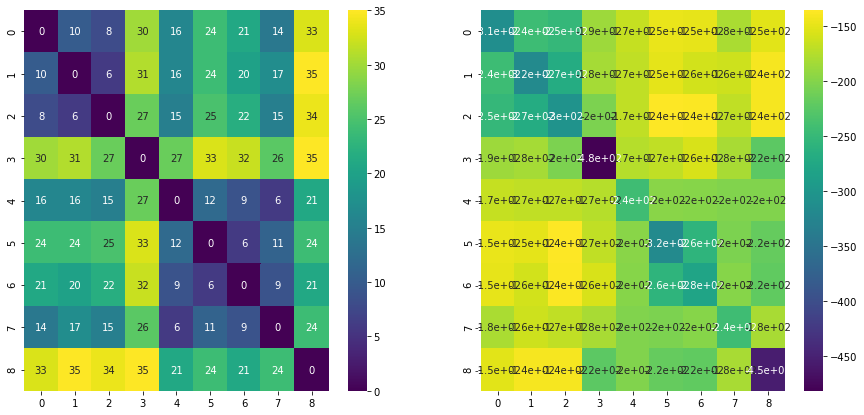

In [936]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

D = np.copy(pdms['total'])
Q = np.zeros(D.shape)
r = D.shape[0]

for i in range(0, r):
    for j in range(0, r):
        Q[i, j] =  (r - 2) * D[i, j] - sum(D[i,]) - sum(D[j, ])

sns.heatmap(pdms['total'], ax=axs[0], cmap='viridis', annot=True)
sns.heatmap(Q, ax=axs[1], cmap='viridis', annot=True)

In [937]:
nj_tree_wout_root.total_branch_length(), final.total_branch_length()

(75.6640625, 75.6640625)

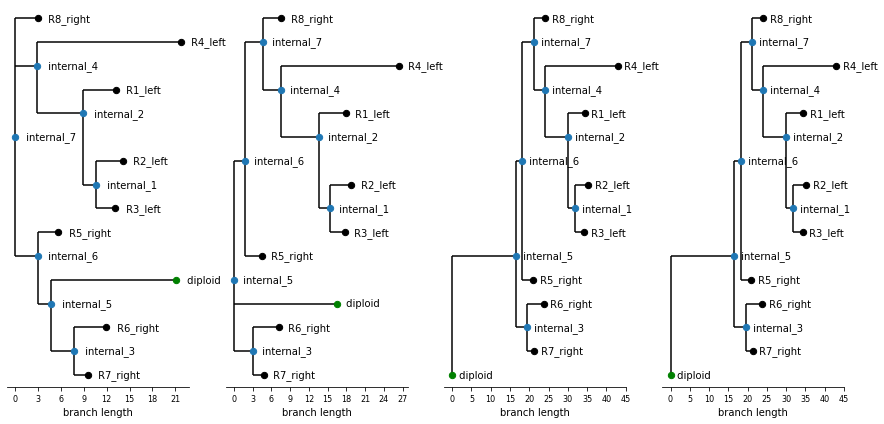

In [938]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 7))

plot_tree(nj_tree_wout_root, label_func, ax=axs[0])
plot_tree(input_tree, label_func, ax=axs[1])
plot_tree(test, label_func, ax=axs[2])
plot_tree(alt_tree, label_func, ax=axs[3])

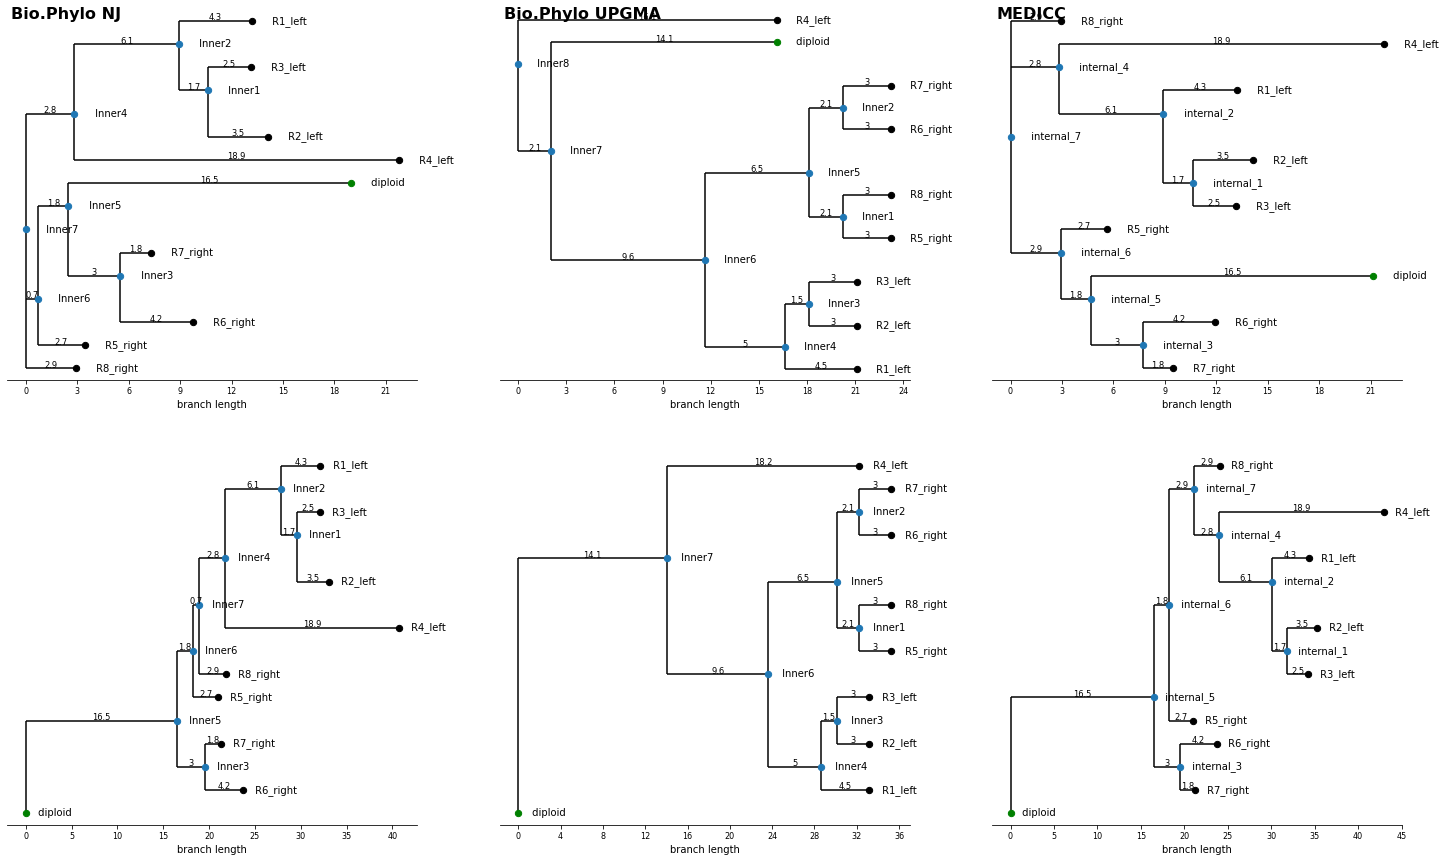

In [939]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceMatrix

dm = pdms['total'].copy()
for i in range(dm.shape[0]):
    for j in range(dm.shape[1]):
        if j > i:
            dm[i, j] = 0
dm = [list(x)[:(i+1)] for i, x in enumerate(dm)]

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(25, 15))

constructor = DistanceTreeConstructor()
tree = constructor.nj(DistanceMatrix(list(sample_labels), matrix=dm))
plot_tree(tree, label_futreenc, ax=axs[0, 0], title='Bio.Phylo NJ', plot_branch_lengths=True)
tree.root_with_outgroup('diploid')
plot_tree(tree, label_func, ax=axs[1, 0], plot_branch_lengths=True)

tree = constructor.upgma(DistanceMatrix(list(sample_labels), matrix=dm))
plot_tree(tree, label_func, ax=axs[0, 1], title='Bio.Phylo UPGMA', plot_branch_lengths=True)
tree.root_with_outgroup('diploid')
plot_tree(tree, label_func, ax=axs[1, 1], plot_branch_lengths=True)

plot_tree(nj_tree_wout_root, label_func, ax=axs[0, 2], title='MEDICC', plot_branch_lengths=True)
plot_tree(final, label_func, ax=axs[1, 2], plot_branch_lengths=True)

plt.show()

Create random trees

In [1128]:
asymm_fst = fstlib.read(os.path.join('../objects', 'wgd_asymm.fst'))
FSA_dicts = [medicc.core.create_standard_fsa_dict_from_allele_column(input_df[c], asymm_fst.input_symbols(), 'X') for c in input_df]

def ancestor_update(final_tree, normal_name='diploid'):
    
    tmpsearch = [c for c in final_tree.find_clades(name = normal_name)]
    diploid = tmpsearch[0]
    root_path = final_tree.get_path(normal_name)[::-1]

    if len(root_path)>1:
        new_root = root_path[1]
        final_tree.root_with_outgroup(new_root)
    
    medicc.tools.set_sequences_on_tree(final_tree, FSA_dicts, input_df.columns)
    
    ancestors = [medicc.reconstruct_ancestors(tree = final_tree, 
                                                    samples_dict = fsa_dict, 
                                                    model = asymm_fst, 
                                                    normal_name = normal_name)
                    for fsa_dict in FSA_dicts] 

    ## Update branch lengths with ancestors
    medicc.tools.set_sequences_on_tree(final_tree, ancestors, input_df.columns)
    medicc.core.update_branch_lengths(final_tree, asymm_fst, ancestors, normal_name)

In [1122]:
nj_object = medicc.nj.NeighbourJoining(pdms['total'], sample_labels)
original_tree = nj_object.tree
original_tree.root_with_outgroup('diploid')
medicc.tools.set_sequences_on_tree(original_tree, FSA_dicts, input_df.columns)
best_score = np.inf
best_tree = None

for _ in tqdm(range(100)):
    cur_tree = nj_object.random_tree()
    ancestor_update(cur_tree)
    cur_tree.root_with_outgroup('diploid')
    cur_score = cur_tree.total_branch_length()
    
    if cur_score < best_score:
        best_score = cur_score
        best_tree = cur_tree

  0%|          | 0/10 [00:00<?, ?it/s]

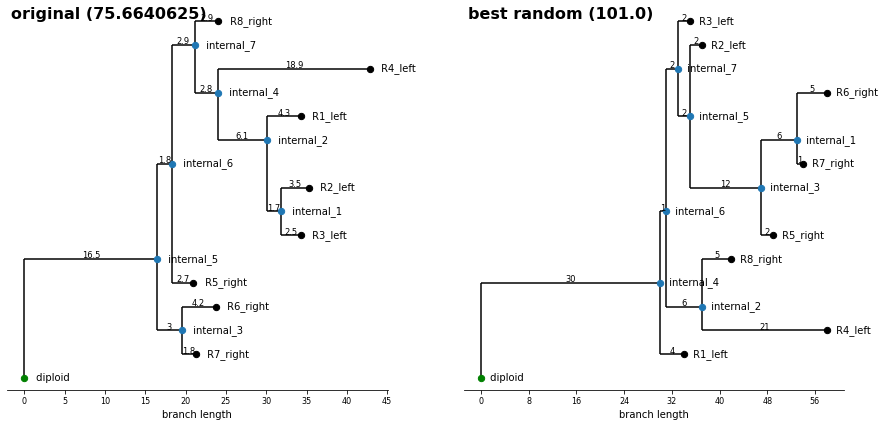

In [1126]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(15, 7))

plot_tree(original_tree, label_func, ax=axs[0], plot_branch_lengths=True, title='original ({})'.format(original_tree.total_branch_length()))
plot_tree(best_tree, label_func, ax=axs[1], plot_branch_lengths=True, title='best random ({})'.format(best_score))

Create tree by hand and calculate length

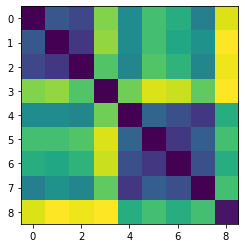

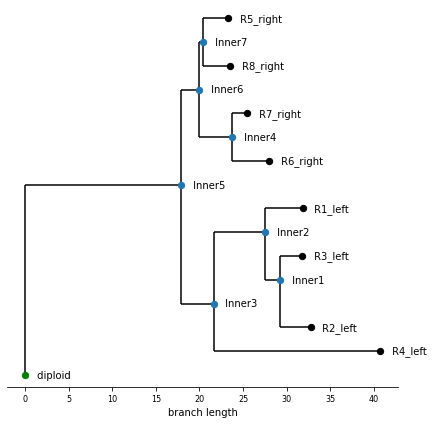

In [1169]:
mod_dm = np.copy(pdms['total'])
val = 2
mod_dm += val
mod_dm[:4, :4] = mod_dm[:4, :4] - val
mod_dm[4:-1, 4:-1] = mod_dm[4:-1, 4:-1] - val

plt.imshow(mod_dm)
plt.show()
for i in range(mod_dm.shape[0]):
    for j in range(mod_dm.shape[1]):
        if j > i:
            mod_dm[i, j] = 0
mod_dm = [list(x)[:(i+1)] for i, x in enumerate(mod_dm)]

constructor = DistanceTreeConstructor()
tree = constructor.nj(DistanceMatrix(list(sample_labels), matrix=mod_dm))
tree.root_with_outgroup('diploid')

plot_tree(tree, label_func)

linkage in scipy

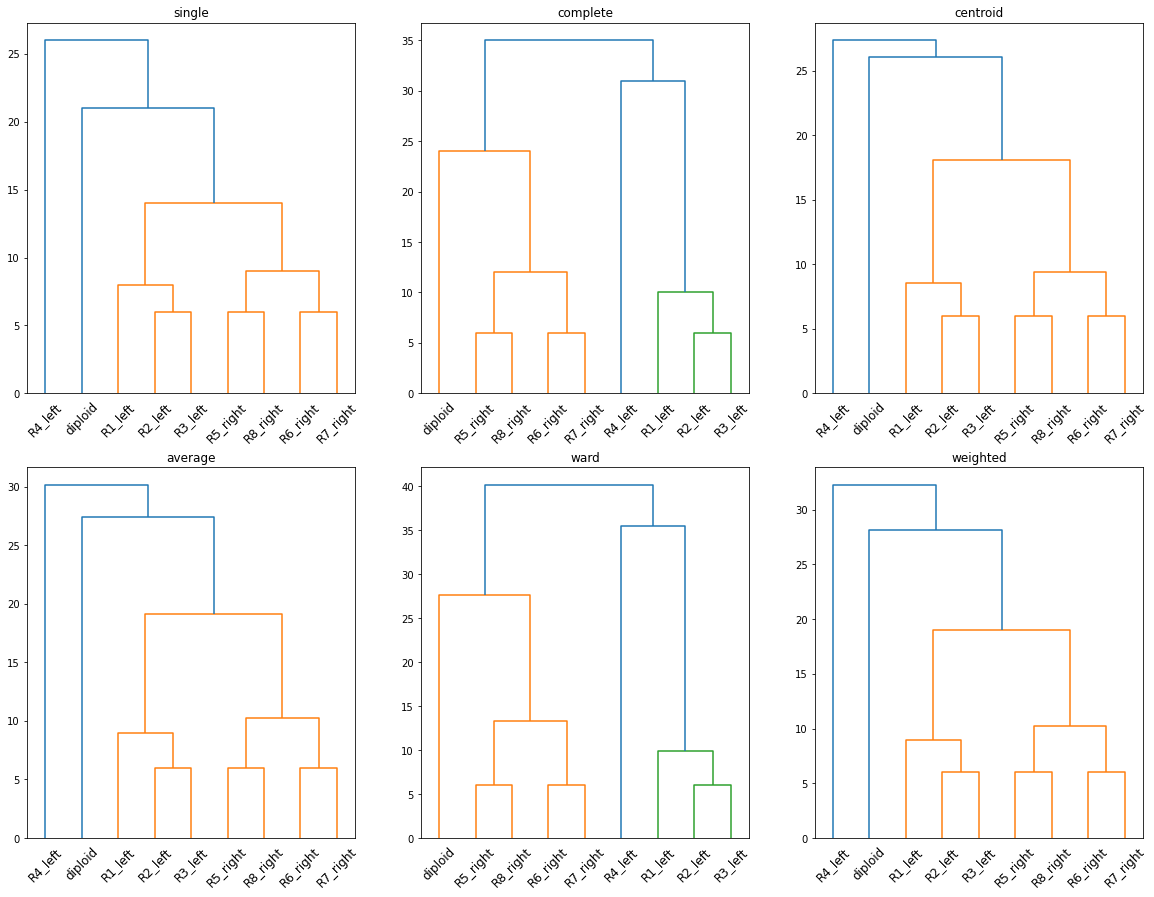

In [766]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 15))
axs = axs.ravel()

for ax, method in zip(axs, ['single', 'complete', 'centroid', 'average', 'ward', 'weighted']):
    Z = linkage(squareform(pdms['total']), method=method)
    dendrogram(Z, ax=ax)
    ax.set_title(method)
    ax.set_xticklabels([samples[int(x.get_text())]for x in ax.get_xticklabels()], rotation=45)

plt.show()

### Add noise and compare

In [7]:
# from https://biopython.org/wiki/Phylo
from Bio.Phylo.Consensus import _BitString

def _bitstrs(tree):
    bitstrs = set()
    term_names = [term.name for term in tree.get_terminals()]
    term_names.sort()
    for clade in tree.get_nonterminals():
        clade_term_names = [term.name for term in clade.get_terminals()]
        boolvals = [name in clade_term_names for name in term_names]
        bitstr = _BitString("".join(map(str, map(int, boolvals))))
        bitstrs.add(bitstr)
    return bitstrs


def compare_trees(tree1, tree2):
    term_names1 = [term.name for term in tree1.get_terminals()]
    term_names2 = [term.name for term in tree2.get_terminals()]
    # false if terminals are not the same
    if set(term_names1) != set(term_names2):
        print('wrong terminal names')
        return False
    # true if _BitStrings are the same
    if _bitstrs(tree1) == _bitstrs(tree2):
        return True
    else:
        return False

In [8]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
axs = axs.ravel()

plot_tree(final_tree, label_func, ax = axs[0], title='original')

titles = {True: 'same', False: 'different'}

for ax in axs[1:]:

    mod_dm = np.copy(pdms['total'])
    mod_dm += np.random.uniform(0, 2, size=(mod_dm.shape))

    for i in range(mod_dm.shape[0]):
        for j in range(mod_dm.shape[1]):
            if j > i:
                mod_dm[i, j] = 0
    mod_dm = [list(x)[:(i+1)] for i, x in enumerate(mod_dm)]

    constructor = DistanceTreeConstructor()
    tree = constructor.nj(DistanceMatrix(list(sample_labels), matrix=mod_dm))
    tree.root_with_outgroup('diploid')

    plot_tree(tree, label_func, ax = ax, title=titles[compare(original_tree, tree)])
    
plt.show()

fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(20, 20))
axs = axs.ravel()

plot_tree(final_tree, label_func, ax = axs[0], title='original')

for ax in axs[1:]:

    mod_dm = np.copy(pdms['total'])
    mod_dm += np.random.uniform(0, 5, size=(mod_dm.shape))

    for i in range(mod_dm.shape[0]):
        for j in range(mod_dm.shape[1]):
            if j > i:
                mod_dm[i, j] = 0
    mod_dm = [list(x)[:(i+1)] for i, x in enumerate(mod_dm)]

    constructor = DistanceTreeConstructor()
    tree = constructor.nj(DistanceMatrix(list(sample_labels), matrix=mod_dm))
    tree.root_with_outgroup('diploid')

    plot_tree(tree, label_func, ax = ax, title=titles[compare(original_tree, tree)])
    
plt.show()

NameError: name 'final_tree' is not defined

In [17]:
def pertubate_distance_matrix(original_tree, dm, sample_labels, sigmas=np.arange(0, 3, 0.25), 
                              N=100, use_medicc_nj=True, show_tqdm=True, keep_zero_dist=True):

    all_sums = []

    for sigma in tqdm(sigmas, disable=not show_tqdm):
        cur_sum = 0
        for _ in range(N):
            mod_dm = np.copy(dm)
            mod = np.random.normal(0, sigma, size=(mod_dm.shape))
            mod = 0.5*(mod + mod[::-1, ::-1])
            mod_dm += mod

            mod_dm[mod_dm<0] = 0
            np.fill_diagonal(mod_dm, 0.)
            
            if keep_zero_dist:
                mod_dm[dm == 0] = 0
  
            if use_medicc_nj:
                tree = medicc.core.infer_tree_topology(mod_dm, sample_labels, diploid = 'diploid')
            else:
                for i in range(mod_dm.shape[0]):
                    for j in range(mod_dm.shape[1]):
                        if j > i:
                            mod_dm[i, j] = 0

                mod_dm = [list(x)[:(i+1)] for i, x in enumerate(mod_dm)]
                constructor = DistanceTreeConstructor()
                tree = constructor.nj(DistanceMatrix(list(sample_labels), matrix=mod_dm))
            tree.root_with_outgroup('diploid')

            cur_sum += compare_trees(original_tree, tree)
        all_sums.append(cur_sum / N)

    return sigmas, all_sums

In [37]:
# filter_segment_length = 5e5
filter_segment_length = 0


sum_list = []
nj_trees = []
dms = []
samples = []

for cur_file, ax in tqdm(zip(files, axs), total=len(files)):
    patient_stx = cur_file.split('_')[2]
    patient_orig = patient_dict[patient_stx]
    input_df = medicc.io.read_and_parse_input_data(
        os.path.join(data_folder, cur_file),
        normal_name,
        'tsv',
        'X',
        ['A', 'B'])
    input_df.rename({'A': 'cn_a', 'B': 'cn_b'}, axis=1, inplace=True)

    if filter_segment_length > 0:
        input_df.reset_index(inplace=True)
        input_df['segment_length'] = input_df['end'] - input_df['start']
        input_df = input_df.loc[input_df['segment_length'] > filter_segment_length]

        input_df.set_index(['sample_id', 'chrom', 'start', 'end'], inplace=True)
        input_df.sort_index(inplace=True)
        input_df = input_df[['cn_a', 'cn_b']]

    # phased
    sample_labels, pdms, nj_tree, final_tree, output_df = medicc.main(
        input_df,
        fst_wgd,
        normal_name,
        input_tree=None,
        ancestral_reconstruction=True,
        chr_separator='X')
    
    sigmas, all_sums = pertubate_distance_matrix(nj_tree, pdms['total'], sample_labels, N=100, show_tqdm=False)
    
    sum_list.append(all_sums)
    dms.append(pdms['total'])
    nj_trees.append(nj_tree)
    samples.append(sample_labels)
    
plt.show()

  0%|          | 0/15 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(10, 10))
order = np.argsort([np.sum(s) for s in sum_list])

for i in order:
    s = sum_list[i]
    cur_file = files[i]
    
    patient_stx = cur_file.split('_')[2]
    patient_orig = patient_dict[patient_stx]

    plt.plot(np.arange(0, 3, 0.25), s, 'o-', label='{}_{}'.format(patient_stx, patient_orig))
    
plt.legend()
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols = 3, nrows = len(files), figsize=(20, 7*len(files)))

order = np.argsort([np.sum(s) for s in sum_list])
for i, ax in zip(order, axs):
    cur_file = files[i]
    dm = dms[i]
    nj_tree = nj_trees[i]
    s = sum_list[i]
    labels = samples[i]

    patient_stx = cur_file.split('_')[2]
    patient_orig = patient_dict[patient_stx]

    sns.heatmap(dm, ax=ax[0], cmap='viridis', annot=True)
    plot_tree(nj_tree, label_func, ax=ax[1])
    ax[2].plot(sigmas, s, 'o-')
    
    ax[0].set_xticklabels([label_func(s) for s in labels], rotation=90)
    ax[0].set_yticklabels([label_func(s) for s in labels], rotation=0)
    ax[0].set_title('{}_{}'.format(patient_stx, patient_orig))
    ax[2].set_title(np.sum(s))    
    ax[2].set_ylim(-0.025, 1.025)

## Create overview PPT

In [523]:
BAF_folder = '../../data/sottoriva_BAF_segmentation'
patients_stx = [pat.split('_')[-1] for pat in os.listdir(BAF_folder)]

In [590]:
# Create ppt
title_slide_layout = prs.slide_layouts[5]
title_subtitle_slide_layout = prs.slide_layouts[0]
picture_slide_layout = prs.slide_layouts[8]
blank_slide_layout = prs.slide_layouts[6]

left = pptx.util.Inches(0)
top = pptx.util.Inches(0)
height = pptx.util.Inches(7.5)

def text_on_top(text):
    txBox = slide.shapes.add_textbox(pptx.util.Inches(2), pptx.util.Inches(0), pptx.util.Inches(8), pptx.util.Inches(1))
    tf = txBox.text_frame
    tf.text = text

prs = pptx.Presentation()

# Title slide
slide = prs.slides.add_slide(title_slide_layout)
title = slide.shapes.title
title.text = 'Sottoriva et al 2015'

for patient_stx in tqdm(patients_stx):
    
    patient_letter = patient_dict[patient_stx]

    # Title slide
    slide = prs.slides.add_slide(title_slide_layout)
    title = slide.shapes.title
    title.text = '{}_{}'.format(patient_stx, patient_letter)
    
    # Add BAF
#     slide = prs.slides.add_slide(picture_slide_layout)
#     BAF_file = os.path.join(BAF_folder, 'C_' + patient_stx, 'snp_array', 'ASCAT', )
#     placeholder = slide.placeholders[1]
#     pic = placeholder.insert_picture(chart)

    # Add MEDICC CNP
    cur_dir = '../../results/sottoriva_bafseq/filter_0'
    img_path = os.path.join(cur_dir, '{}_{}_phased_WGD_cn_profiles.jpg'.format(patient_stx, patient_letter))
    if os.path.isfile(img_path):
        slide = prs.slides.add_slide(picture_slide_layout)
        pic = slide.shapes.add_picture(img_path, left, top, height=height)

    # Add Trees
    slide = prs.slides.add_slide(picture_slide_layout)
    cur_dir = '../../results/sottoriva_bafseq/filter_0'
    img_path = os.path.join(cur_dir, '{}_{}_phased_WGD_tree.png'.format(patient_stx, patient_letter))
    pic = slide.shapes.add_picture(img_path, left, top, height=height)
    text_on_top('no filter - phased - WGD')
    
    slide = prs.slides.add_slide(blank_slide_layout)
    cur_dir = '../../results/sottoriva_bafseq/comparison'
    img_path = os.path.join(cur_dir, '{}_{}.png'.format(patient_stx, patient_letter))
    pic = slide.shapes.add_picture(img_path, left, top, height=height)
    
prs.save('../../results/Sottoriva_overview.ppt')

  0%|          | 0/15 [00:00<?, ?it/s]

/home/tom/anaconda3/envs/medicc_env/lib/python3.9/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (105024000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/tom/anaconda3/envs/medicc_env/lib/python3.9/site-packages/PIL/Image.py:2847: DecompressionBombWarning: Image size (108640000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
/home/tom/anaconda3/envs/medicc_env/lib/python3.9/zipfile.py:1505: UserWarning: Duplicate name: 'ppt/slideLayouts/slideLayout6.xml'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/tom/anaconda3/envs/medicc_env/lib/python3.9/zipfile.py:1505: UserWarning: Duplicate name: 'ppt/slideLayouts/_rels/slideLayout6.xml.rels'
  return self._open_to_write(zinfo, force_zip64=force_zip64)
/home/tom/anaconda3/envs/medicc_env/lib/python3.9/zipfile.py:1505: UserWarning: Duplicate name: 'ppt/slideMasters/slideMaster1.xml'
  return se

# Measure of confidence